In [ ]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall gensim
!pip install pandas==2.0.3  # Install a compatible version of pandas to align with gensim
!pip install gensim

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 2.0.3 which is incompatible.
xarray 2025.1.2 requires pandas>=2.1, but you have pandas 2.0.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
plotnine 0.14.5 requires pandas>=

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
^C


Vocabulary Size: 4346 - Embedding Dim: 100
[('anxiety', 0.8232187628746033), ('mental', 0.7670772671699524), ('dealt', 0.7530271410942078)]
[('depression', 0.7360830903053284), ('pain', 0.7339973449707031), ('anxiety', 0.7043114304542542)]
[('okay', 0.8531861305236816), ('honest', 0.8281877040863037), ('sad', 0.8242671489715576)]
(3113, 200)
(3113,)
Train Shapes - X: (2647, 200) - Y: (2647,)
Val Shapes - X: (466, 200) - Y: (466,)


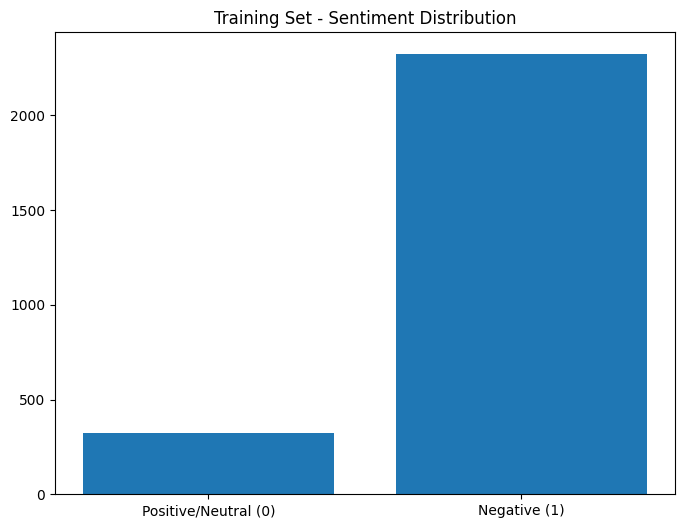

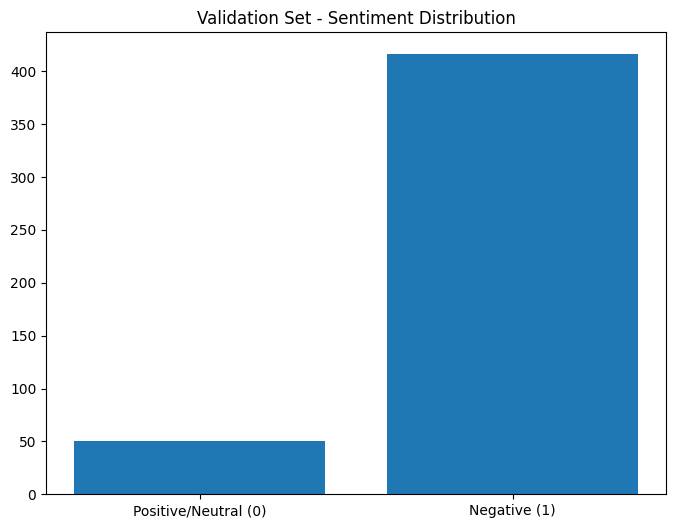

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8400 - loss: 0.5826 - val_accuracy: 0.8927 - val_loss: 0.5224
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8700 - loss: 0.5392 - val_accuracy: 0.8927 - val_loss: 0.5092
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8797 - loss: 0.5125 - val_accuracy: 0.8927 - val_loss: 0.4965
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8797 - loss: 0.4919 - val_accuracy: 0.8927 - val_loss: 0.4831
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8847 - loss: 0.4741 - val_accuracy: 0.8863 - val_loss: 0.4772


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │       434,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 616,105 (2.35 MB)

 Trainable params: 60,501 (236.33 KB)

 Non-trainable params: 434,600 (1.66 MB)

 Optimizer params: 121,004 (472.68 KB)

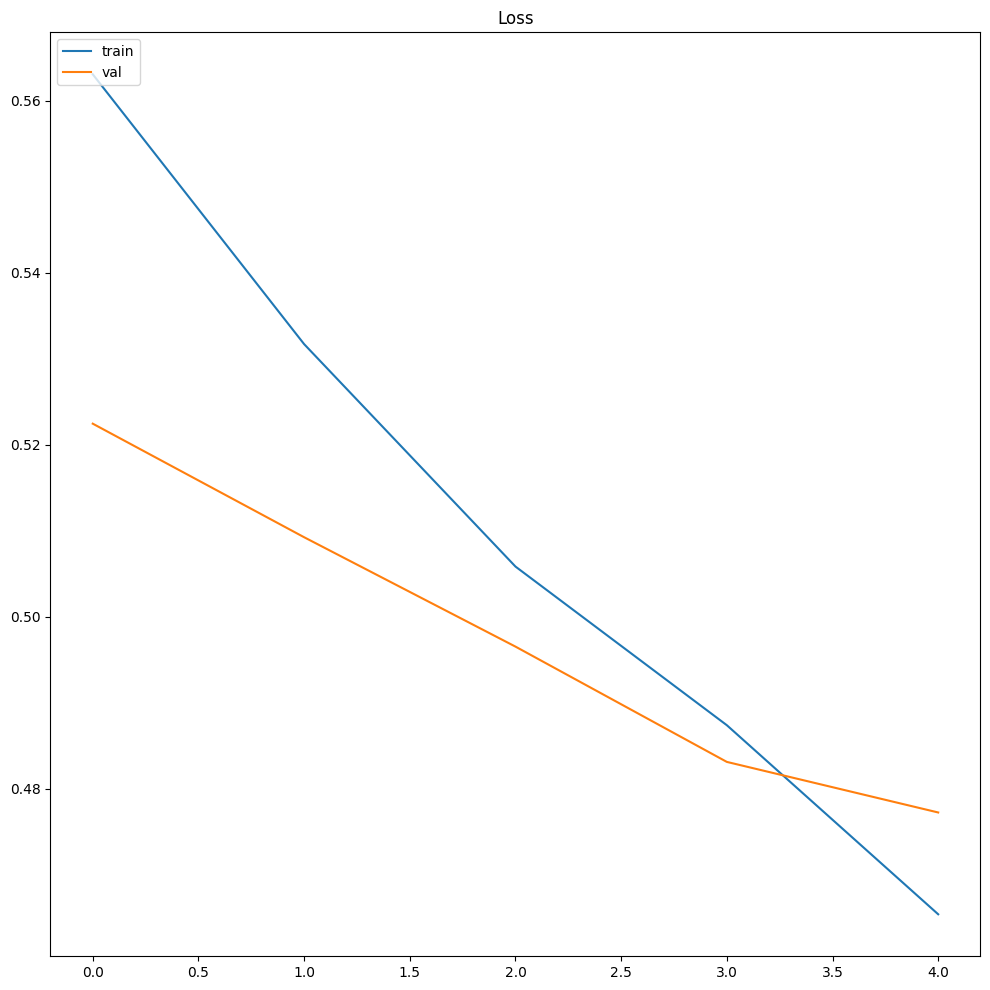

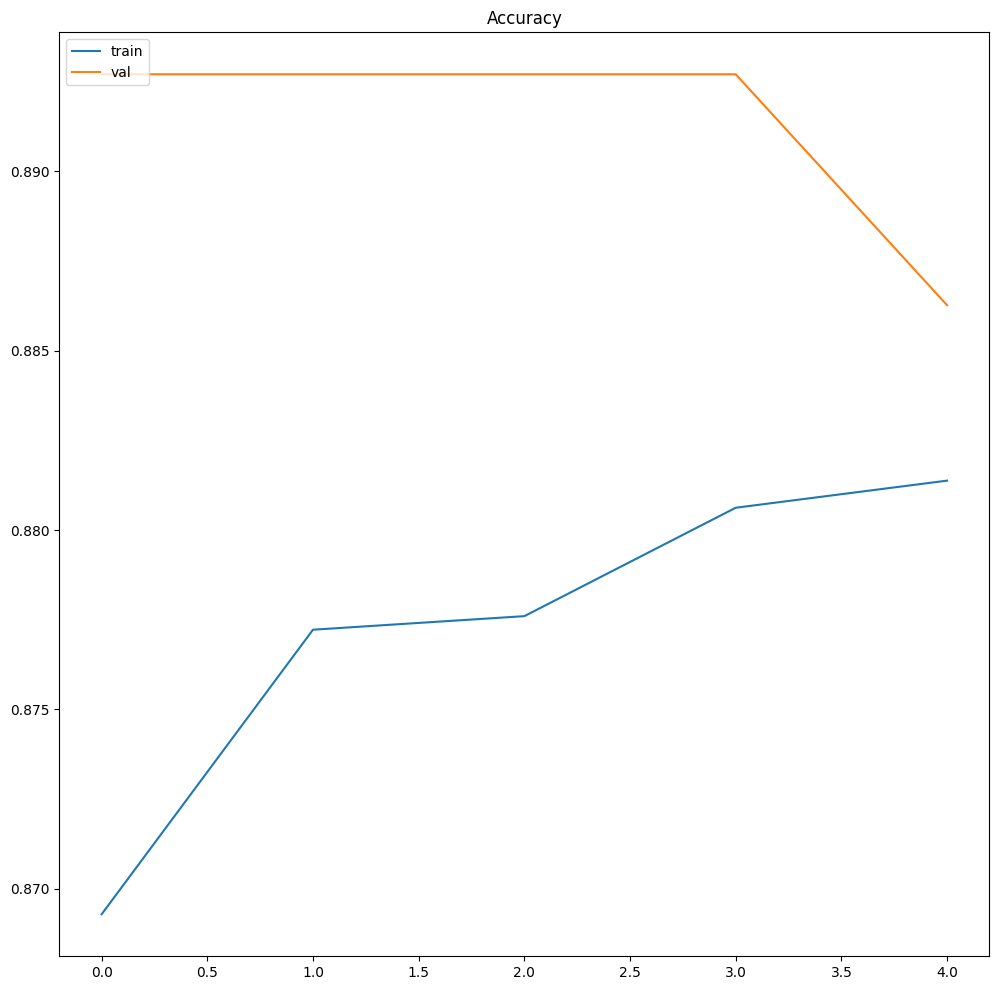

In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('Reddit_Combi.csv', delimiter=';')
df = df.dropna(subset=['body'])  # Use 'body' column as primary text
df = df.iloc[:, [1, 3]]  # Use 'body' and 'label' columns

# Create an iterator object that returns words properly formatted for Word2Vec training
class TextIterator:
    def __init__(self, dataset):
        self.dataset = dataset
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for text in self.dataset.iloc[:, 0]:
            text = text.lower()
            for sentence in text.split('.')[:-1]:
                sentence = sentence.translate(self.translator)
                words = [w for w in sentence.split(' ') if w != '']
                yield words

sentences = TextIterator(df)

## Word2Vec Model
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=8)
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Validation
print(w2v_model.wv.most_similar('depression', topn=3))
print(w2v_model.wv.most_similar('stress', topn=3))
print(w2v_model.wv.most_similar('happy', topn=3))

def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return w2v_model.wv.index_to_key[token]

## Preparing data as sequences for LSTM
MAX_SEQUENCE_LENGTH = 200

class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset
        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.seq_length = seq_length

    def __iter__(self):
        for text, label in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            text = text.lower()
            text = text.translate(self.translator)
            words = np.array([word2token(w) for w in text.split(' ')[:self.seq_length] if w != ''])
            yield (words, label)

sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH)

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(c)

set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

## Splitting dataset in training and validation
VALID_PER = 0.15

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Visualize label distribution
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(8, 6))
plt.title("Training Set - Sentiment Distribution")
plt.xticks([0, 1], ['Positive/Neutral (0)', 'Negative (1)'])
plt.bar([0, 1], ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(8, 6))
plt.title("Validation Set - Sentiment Distribution")
plt.xticks([0, 1], ['Positive/Neutral (0)', 'Negative (1)'])
plt.bar([0, 1], ccount, align='center')
plt.show()

n_categories = len(np.unique(set_y))

## Defining and Training LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

MAX_SEQUENCE_LENGTH = 50
train_x = pad_sequences(train_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
val_x = pad_sequences(val_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Changed to 1 unit for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(train_x, train_y, epochs=5, batch_size=32,
                    validation_data=(val_x, val_y), verbose=1,
                    callbacks=[early_stopping])

model.summary()

# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Vocabulary Size: 4346 - Embedding Dim: 100
[('anxiety', 0.8124967217445374), ('mental', 0.77578204870224), ('dealing', 0.7707068920135498)]
[('pain', 0.7422763705253601), ('anxiety', 0.6934477686882019), ('depression', 0.6839505434036255)]
[('okay', 0.827889621257782), ('sad', 0.8181381821632385), ('alone', 0.8180114030838013)]


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


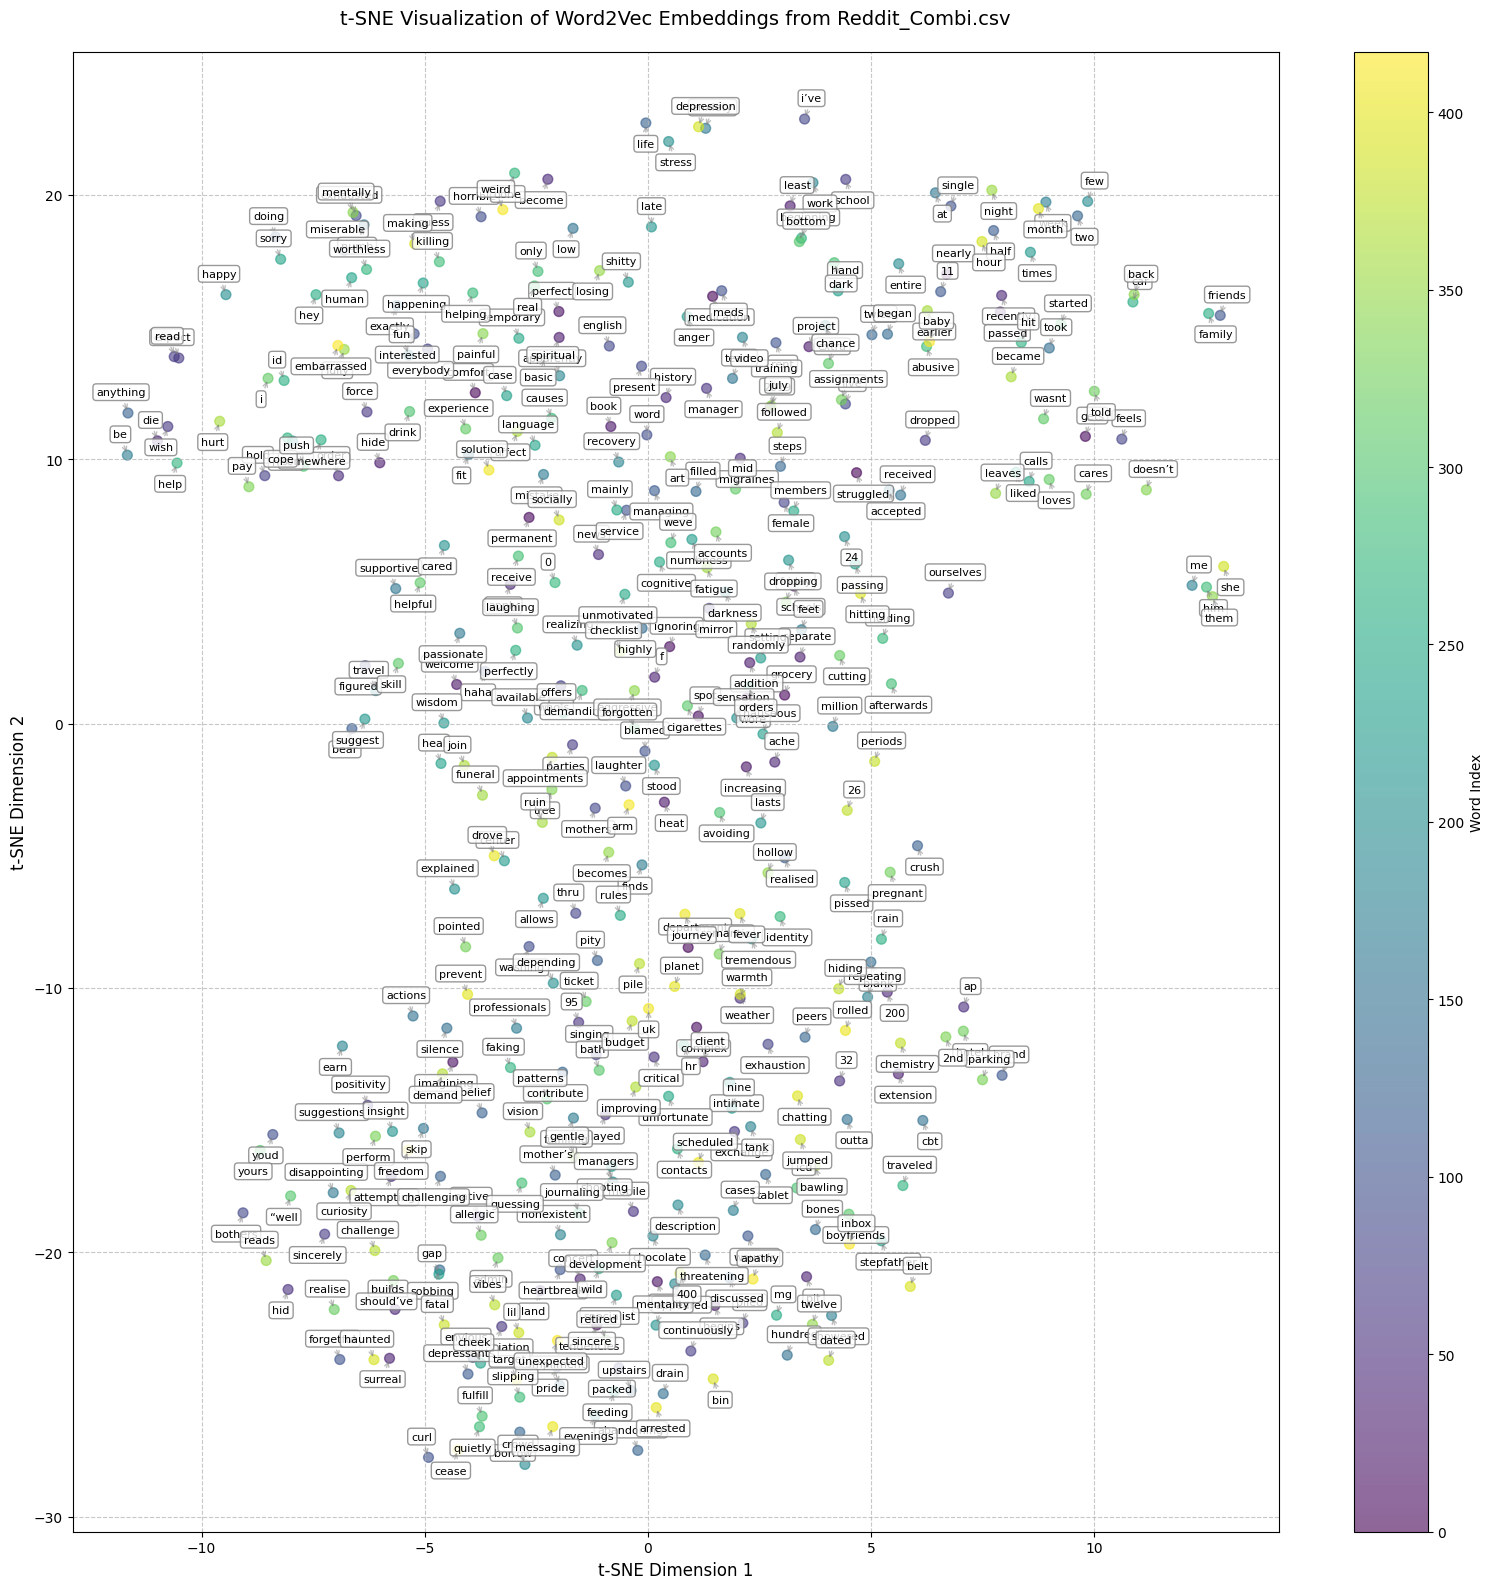

In [ ]:


from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import gensim
import numpy as np
import pandas as pd
import string
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load dataset
df = pd.read_csv('Reddit_Combi.csv', delimiter=';')
df = df.dropna(subset=['body'])  # Use 'body' column as primary text
df = df.iloc[:, [1, 3]]  # Use 'body' and 'label' columns

# Create an iterator object that returns words properly formatted for Word2Vec training
class TextIterator:
    def __init__(self, dataset):
        self.dataset = dataset
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for text in self.dataset.iloc[:, 0]:
            text = text.lower()
            for sentence in text.split('.')[:-1]:
                sentence = sentence.translate(self.translator)
                words = [w for w in sentence.split(' ') if w != '']
                yield words

sentences = TextIterator(df)

## Word2Vec Model
w2v_model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=8)
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Validation
print(w2v_model.wv.most_similar('depression', topn=3))
print(w2v_model.wv.most_similar('stress', topn=3))
print(w2v_model.wv.most_similar('happy', topn=3))

def word2token(word):
    try:
        return w2v_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return w2v_model.wv.index_to_key[token]
n_samples = min(500, vocab_size)  # Limit to 500 or vocab_size if smaller
# Sample random words from model dictionary, prioritizing sentiment-related terms
sentiment_words = ['depression', 'stress', 'happy', 'anxiety', 'life', 'die', 'help', 'family', 'work', 'friends']
# Ensure population size is at least n_samples
population = [i for i in range(vocab_size) if token2word(i) in sentiment_words or random.random() < 0.1]
# Adjust n_samples if population is smaller
n_samples = min(n_samples, len(population))
random_i = random.sample(population, n_samples)
random_w = [token2word(i) for i in random_i if token2word(i) in w2v_model.wv]  # Ensure valid words
word_vecs = np.array([w2v_model.wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)  # Added parameters for reproducibility
tsne_e = tsne.fit_transform(word_vecs)

# Create a figure with improved size and layout
plt.figure(figsize=(16, 16))
plt.title('t-SNE Visualization of Word2Vec Embeddings from Reddit_Combi.csv', fontsize=14, pad=20)

# Scatter plot with improved aesthetics
scatter = plt.scatter(tsne_e[:, 0], tsne_e[:, 1],
                      marker='o',
                      c=range(len(random_w)),
                      cmap='viridis',  # Changed to viridis for better color contrast
                      alpha=0.6,  # Added transparency to handle overlap
                      s=50)  # Adjusted size for clarity

# Add colorbar for reference
plt.colorbar(scatter, label='Word Index')

# Annotate words with improved label placement and styling
for i, (label, x, y) in enumerate(zip(random_w, tsne_e[:, 0], tsne_e[:, 1])):
    # Adjust text position to avoid overlap, using a small offset
    offset_x = 0 if abs(x) < 0.1 else (x / abs(x)) * 5  # Dynamic offset based on x direction
    offset_y = 15 if i % 2 == 0 else -15  # Alternate vertical offset
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(offset_x, offset_y),
                 textcoords='offset points',
                 ha='center',
                 va='center',
                 fontsize=8,  # Reduced font size for readability
                 bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.8),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gray', alpha=0.5))

# Customize plot
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
!pip install keras